# Get sorted spikes and bouts and make rasters/gpfa

For every run in the session:
 - Load the recordings
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts
- sort_raster_bout:
    - syncrhonization of nidaq/ap time events
    - spike sorting
    - labeling of sorted units for their corresponding nucleus
    - inspection of rasters
    
This notebook should not depend on the raw_data

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import socket
import tempfile
import multiprocessing
import threading
import json

import numpy as np
import pandas as pd

import scipy
from scipy.io import wavfile
from scipy import signal
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

N_JOBS_MAX = multiprocessing.cpu_count()

logger.info('Running on {}'.format(socket.gethostname()))

2023-01-26 09:20:08,389 root         INFO     Running on pakhi.ucsd.edu


In [2]:
from ceciestunepipe.file import bcistructure as et

from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import sglxsync as sy
from ceciestunepipe.util import stimutil as su
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util import fileutil as fu
from ceciestunepipe.util import h5util as h5u
from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

from ceciestunepipe.pipeline import searchbout as sb

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2023-01-26 09:20:09,860 root         INFO     all modules loaded


### Session parameters

In [3]:
reload(et)

bird = 's_b1238_22'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [4]:
reload(et)

sess_par = {'bird': bird,
           'sess': '2022-02-12',
           'probe': 'probe_0',
           'sort': 'sort_0',
           'trial_tag_chan': 0, # what whas the tag channel in the stimulus wave (this should come from meta et. al)
            'on_signal': 1, # whether singnal on is hi or lo
            'ref_stream': 'ap_0', #what to syncrhonize everything to
           'stim_sess': None, # if there was a stimulus epoch, where the stimuli were coming from
           'mic_chan': 0, # where the microphone is in the wav_mic.npy array
           'pre_chan': 0} # where the pressure is in the wav_adc.npy array




In [5]:
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2023-01-26 09:20:09,896 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1238_22', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-02-12', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-02-12/sglx', 'kwik': '/scratch/earneodo/s_b1238_22/sglx/kwik/2022-02-12', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1238_22/2022-02-12/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-02-12/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1238_22/sglx/msort/2022-02-12', 'ksort': '/scratch/earneodo/s_b1238_22/sglx/ksort/2022-02-12/sort_0', 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-02-12/sglx/sort_0'}, 'files': {'par': '/scratch/earneodo/s_b1238_22/sglx/ksort/2022-02-12/sort_0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-02-12/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-02-12/sglx/rig.json', 'kwd': '/scratch/

['0716_g0', '1141_stim_g0', '1607_g0', '2212_g0']

In [6]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] #
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

derived_folder = exp_struct['folders']['derived']

In [7]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/0716_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-02-12/0716_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-02-12/sglx/0716_g0',
  'kwik': '/scratch/earneodo/s_b1238_22/sglx/kwik/2022-02-12/0716_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1238_22/2022-02-12/sglx/0716_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-02-12/sglx/0716_g0',
  'tmp': '/scratch/earneodo/tmp/0716_g0',
  'msort': '/scratch/earneodo/s_b1238_22/sglx/msort/2022-02-12/0716_g0',
  'ksort': '/scratch/earneodo/s_b1238_22/sglx/ksort/2022-02-12/0716_g0/sort_0',
  'sort': '/mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-02-12/sglx/0716_g0/sort_0'},
 'files': {'par': '/scratch/earneodo/s_b1238_22/sglx/ksort/2022-02-12/0716_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-02-12/sglx/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-0

### load epoch files

In [8]:
### get the spikes df, clu df, bouts and syncrhonization files

## the sort
sort_folder = os.path.join(exp_struct['folders']['derived'], sess_par['sort'])

logger.info('Loading sort files from ' + sort_folder)

clu_df_path = os.path.join(sort_folder, 'clu_df.pickle')
clu_df = pd.read_pickle(clu_df_path)

spk_df_path = os.path.join(sort_folder, 'spk_df.pickle')
spk_df = pd.read_pickle(spk_df_path)


## the bout/stim
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'bout_dict_ap0.pkl')
bout_df_path = os.path.join(exp_struct['folders']['derived'], 'bout_pd_ap0.pkl')

logger.info('loading synced bout and dict and pandas dataframe from {}, {}'.format(bout_dict_path, bout_df_path))
with open(bout_dict_path, 'rb') as handle:
    bout_dict = pickle.load(handle)
bout_df = pd.read_pickle(bout_df_path)

#load the mic, pressure if any
mic_path = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
adc_path = os.path.join(exp_struct['folders']['derived'], 'wav_adc.wav')

s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'], sess_par['mic_chan'])

#s_f_wav, pre_stream = wu.read_wav_chan(adc_path, sess_par['pre_chan'])
pre_stream = np.abs(mic_stream)

ap_sf = bout_dict['s_f_ap_0']

2023-01-26 09:20:09,941 root         INFO     Loading sort files from /mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-02-12/sglx/0716_g0/sort_0
2023-01-26 09:20:10,928 root         INFO     loading synced bout and dict and pandas dataframe from /mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-02-12/sglx/0716_g0/bout_dict_ap0.pkl, /mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-02-12/sglx/0716_g0/bout_pd_ap0.pkl


### set other parameters

In [9]:
# cut_off for spike filer
spk_fr_cutoff = 0.00001 #spikes/sec
bout_dict['nuclei_list'] = ['ncm']

# collection edges of the bouts
bout_dict['t_pre'] = -10
bout_dict['t_post'] = 10

# specify fitting parameters
bout_dict['gpfa_bin_ms'] = 15
#bin_size = gpfa_bin_ms * pq.ms
bout_dict['gpfa_xdim'] = 8

bout_dict['h5_fname'] = 'bout_df_gpfa-{}ms_longtail.h5'.format(bout_dict['gpfa_bin_ms'])

In [10]:
bout_dict_path

'/mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-02-12/sglx/0716_g0/bout_dict_ap0.pkl'

In [11]:
# #load the mic, pressure if any
# mic_path = os.path.join(exp_struct['folders']['derived'], 'wav_mic.npy')
# adc_path = os.path.join(exp_struct['folders']['derived'], 'wav_adc.npy')

# mic_stream = np.memmap(adc_path)

In [12]:
bout_df.keys()

Index(['start_ms', 'end_ms', 'start_sample', 'end_sample', 'p_step', 'rms_p',
       'peak_p', 'bout_check', 'file', 'len_ms', 'syl_in', 'n_syl', 'peaks_p',
       'n_peaks', 'l_p_ratio', 'waveform', 'confusing', 'valid_waveform',
       'valid', 'spectrogram', 'start_ms_ap_0', 'start_sample_ap_0',
       'start_sample_naive'],
      dtype='object')

In [13]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0', 'end_sample_ap_0', 't_pre', 't_post', 'gpfa_bin_ms', 'gpfa_xdim', 'h5_fname'])

In [14]:
spk_df.head(2)

,times,clusters,cluster_id,nucelus,main_chan,kslabel
0,192,487,487,ncm,359,mua
1,239,45,45,NaN,56,mua


In [15]:
clu_df.head(2)

,cluster_id,KSLabel,group,MSLabel,has_template,template,max_chans,main_chan,main_7,main_wav_7,nucleus
40,40,good,good,None,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[52, 55, 63, 54, 58, 51, 49, 47, 59, 57, 56, 6...",52,"[49, 51, 52, 54, 55, 58, 63]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
41,41,good,good,None,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[55, 53, 52, 63, 49, 61, 50, 51, 54, 57, 58, 4...",55,"[49, 50, 52, 53, 55, 61, 63]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


In [16]:
def clu_n_spike(spk_df, cluster_id):
    spk_clu = spk_df[spk_df['cluster_id']==cluster_id]
    
    n_spike = spk_clu.index.size
    return n_spike

clu_n_spike(spk_df, 564)

0

In [17]:
def fill_clu_meta(clu_df, spk_df):
    # mean FR
    clu_df['n_spike'] = clu_df['cluster_id'].apply(lambda x: clu_n_spike(spk_df, x))

fill_clu_meta(clu_df, spk_df)

In [18]:
t_rec = mic_stream.shape[0]/bout_dict['s_f']
total_ap_samp = t_rec * bout_dict['s_f_ap_0']

#total_ap_samp
n_spk_cutoff = total_ap_samp * spk_fr_cutoff
n_spk_cutoff

4743.507957860245

#### just drop the units without spikes

In [19]:
clu_df = clu_df[clu_df['n_spike']>n_spk_cutoff]
clu_df.reset_index(inplace=True, drop=True)

### Visualize a bout together with the neural traces

In [20]:
plt.rcParams['lines.linewidth'] = 0.1

In [21]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

### collect all the bouts

In [22]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0', 'end_sample_ap_0', 't_pre', 't_post', 'gpfa_bin_ms', 'gpfa_xdim', 'h5_fname'])

In [23]:
def collect_bouts_df(bout_df, bout_dict, spk_df, clu_list, mic_stream, pre_stream, t_pre=-2, t_post=2):
    # get t_pre, t_post in samples for wav, ap
    # tet start_end samples for each
    # collect the spikes
    # collect the streams
    bout_dict['t_pre'] = t_pre
    bout_dict['t_post'] = t_post
    
    sf_ap = bout_dict['s_f_ap_0']
    sf = bout_dict['s_f']
    
    pre_ap, post_ap = [int(x * sf_ap) for x in [t_pre, t_post]]
    pre_wav, post_wav = [int(x * sf) for x in [t_pre, t_post]]
    
    bout_df['len_sample_ap_0'] = (bout_df['len_ms'] * sf_ap * 0.001).astype(int)
    bout_df['end_sample_ap_0'] = bout_df['start_sample_ap_0'] + bout_df['len_sample_ap_0']

    bout_df['spk_arr'] = bout_df.apply(lambda x: ks.get_window_spikes(spk_df, clu_list, 
                                                                      x['start_sample_ap_0'] + pre_ap, 
                                                                      x['end_sample_ap_0'] + post_ap), 
                                       axis=1)

    bout_df['mic_arr'] = bout_df.apply(lambda x: mic_stream[x['start_sample']+pre_wav: x['end_sample']+post_wav], 
                                       axis=1)
    bout_df['pre_arr'] = bout_df.apply(lambda x: pre_stream[x['start_sample']+pre_wav: x['end_sample']+post_wav], 
                                       axis=1)
    
    # while we are at it, compute the spectrograms (ms scale)
    bout_df['sxx'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), sf))
    
    # split the spectrogram to be able to work with hdf5 save/load.
    # don't want to be saving tuples, rather arrays
    bout_df[['f_xx', 't_xx', 's_xx']] = pd.DataFrame(bout_df['sxx'].tolist(), index=bout_df.index)
    
    bout_df['clu_id_arr'] = [clu_list for x in bout_df.index]
    
    return bout_df

In [24]:
### one spk_arr
# mot_idx = 0

# start_ap = bout_df.loc[mot_idx, 'start_sample_ap_0']
# end_ap = bout_df.loc[mot_idx, 'end_sample_ap_0']

# spk_arr = ks.get_window_spikes(spk_df, clu_list, start_ap - 60000 , end_ap+60000)

In [25]:
clu_list = np.unique(clu_df.loc[(clu_df['group']=='good') & (clu_df['nucleus'].isin(bout_dict['nuclei_list']) & (clu_df['n_spike']>n_spk_cutoff)), 
                                'cluster_id'])

bout_df = collect_bouts_df(bout_df, bout_dict, spk_df, clu_list, mic_stream, pre_stream, 
                           t_pre=bout_dict['t_pre'], t_post=bout_dict['t_post'])

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:112: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [26]:
ms_sample_ap = int(1*0.001*bout_dict['s_f_ap_0'])
bout_df['spk_ms_arr'] = bout_df['spk_arr'].apply(lambda z: np.nan_to_num(pu.coarse(z, ms_sample_ap)))

In [27]:
bout_df.index.size

20

In [28]:
def quick_env(x: np.array, avg_bin: int) -> np.array:
    x_env = np.convolve(np.abs(x), np.ones(avg_bin), mode='same')
    return np.log(x_env)

env_ms = 10
env_bin = int(env_ms * 0.001 * bout_dict['s_f'])

bout_df['pre_arr'] = bout_df['mic_arr'].apply(lambda x: quick_env(x, env_bin))

##### sanity check, plot one of the bout-rasters

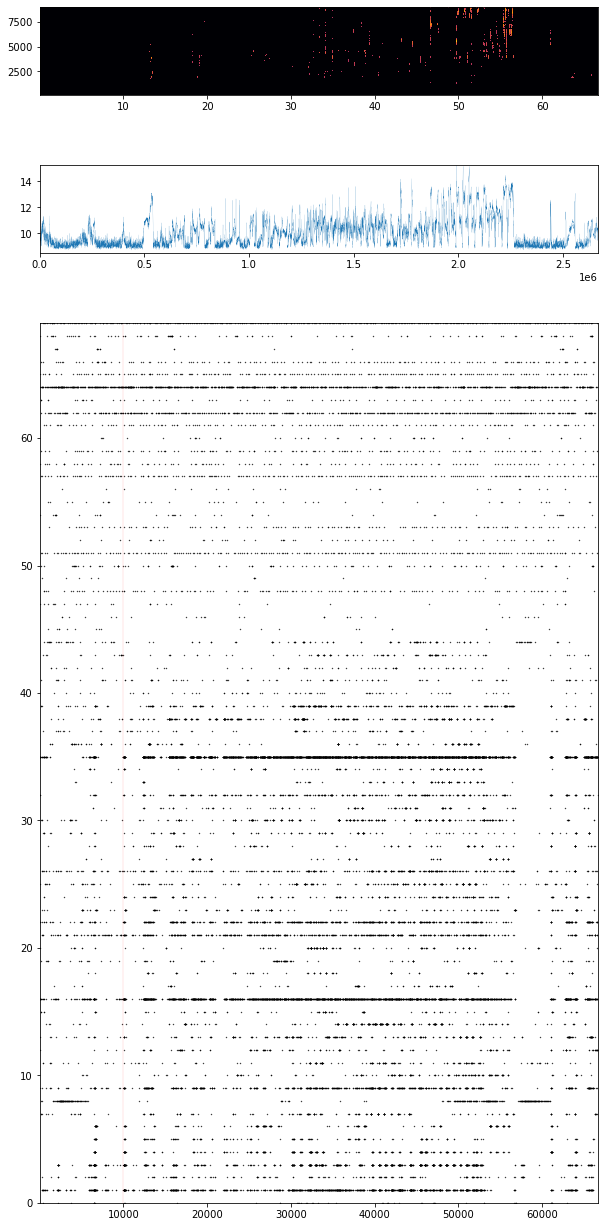

In [29]:
def plot_bout(bout_series, bout_dict):
    # get the raster, the spectrogram and the pressure
    
    t_pre = bout_dict['t_pre']
    s_f_ap = bout_dict['s_f_ap_0']
    s_f = bout_dict['s_f']
    
    mic_arr = bout_series['mic_arr']
    pre_arr = bout_series['pre_arr']
    spk_arr = bout_series['spk_ms_arr']
    # plot
    
    fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

    f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f)

    #ax[0].plot(mic_arr.flatten())
    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[1].plot(pre_arr.flatten());
    pu.plot_as_raster(spk_arr, t_0=int(-t_pre*1000), ax=ax[2])
    
plot_bout(bout_df.iloc[0], bout_dict)

### get all the gpfa

#### Make two separate gpfa fits, one for the vocal part of the bout and one for the 'preparatory' part

In [30]:
# #complete bouts
# bout_df['spk_train'] = bout_df['spk_arr'].apply(lambda x: spike_trains_from_spk_arr(x, bout_dict['s_f_ap_0']))
# all_spk_train_list = list(bout_df['spk_train'])

# #
# bout_spk_train_list = bout_df['spk_arr'].apply(lambda x: spike_trains_from_spk_arr(x, bout_dict['s_f_ap_0'],
#                                                                                    t_pre=t_pre, 
#                                                                                     t_post=t_post)
#                                               )

In [31]:
# prep_spk_train_list = bout_df['spk_arr'].apply(lambda x: spike_trains_from_spk_arr(x, bout_dict['s_f_ap_0'],
#                                                                                    t_pre=0, 
#                                                                                     t_stop=-t_pre)
#                                               )

#### fit the vocal part, project all to this fit

In [32]:
# gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

# #fit
# gpfa_2dim.fit(bout_spk_train_list)

# #project
# bout_fit_list = gpfa_2dim.transform(all_spk_train_list)

# # get to the dataframe
# bout_df['spk_gpf'] = bout_fit_list

#### fit preparatory part, project all to this fit

In [33]:
# gpfa_prep = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

# #fit
# gpfa_prep.fit(prep_spk_train_list)

# #project
# prep_fit_list = gpfa_prep.transform(all_spk_train_list)

# # get to the dataframe
# bout_df['spk_gpf-prep'] = prep_fit_list

### alternative gpfas

In [34]:
from ceciestunepipe.util.dimension import gpfa

# make 4 different fits
- one full
- one to the prepparatory activity
- on to just the bout
- one to the post-bout


In [35]:
spk_train_kwargs_dict = {}

#full
#spk_train_kwargs_dict['full'] = {'s_f': bout_dict['s_f_ap_0']}

#pre
#spk_train_kwargs_dict['pre'] = {'s_f': bout_dict['s_f_ap_0'], 't_pre': 0, 't_stop': -t_pre}

#bout
spk_train_kwargs_dict['bout'] = {'s_f': bout_dict['s_f_ap_0'], 't_pre': bout_dict['t_pre'], 
                                 't_post': bout_dict['t_post']}

#post
# fuck you
#spk_train_kwargs['bout'] = {'s_f': bout_dict['s_f_ap_0'], t_pre=t_pre, t_post=t_post}

In [36]:
bout_df.shape

(20, 34)

In [37]:
bout_df = bout_df

In [46]:
def fit_bout_gpfa(bout_df: pd.DataFrame, bout_dict: dict, spk_train_kwargs_dict, h5_name: str):
    # getting ready for making this a process that:
    # runs the gpfa models
    # gets spectrograms
    # saves to h5 file
    
    # get spectrograms
    logger.info('Getting spectrograms')
    bout_df['sxx'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), bout_dict['s_f']))
    
    # get filtered pressure trace
    logger.info('Filtering pressure')
    b, a = scipy.signal.butter(4, 1000, 'lp', fs=bout_dict['s_f'], output='ba')
    bout_df['pre_filt'] = bout_df['pre_arr'].apply(lambda x: signal.filtfilt(b, a, x))
    
    # get pca
    pca = PCA(n_components=3, svd_solver='full')
    all_x = np.hstack(bout_df['sxx'].apply(lambda x: x[2]))
    all_x[all_x==np.nan] = 1 ### better do a zscore
    # fit all
    pca.fit(np.log(all_x.T))
    # project all
    bout_df['sxx_pc'] = bout_df['sxx'].apply(lambda x: pca.transform(np.log(x[2].T)))
    
    # Get gpfa
    gpfa_keys = []
    gpfa_model_dict = {}
    for k, spk_train_kwargs in spk_train_kwargs_dict.items():
        logger.info('Fitting for {}'.format(k))
        df_key = 'spk_gpf-{}'.format(k)
        gpfa_model_dict[k], bout_df[df_key] = gpfa.gpfa_for_bout(bout_df, bout_dict, 
                                                                 bin_size_ms=bout_dict['gpfa_bin_ms'], 
                                                                 x_dim=bout_dict['gpfa_xdim'], 
                                                                 spk_train_kwargs=spk_train_kwargs)
        gpfa_keys.append(df_key)
    
    attr_keys = ['start_ms', 'end_ms', 'len_ms', 
             'start_sample', 'end_sample',
             'start_ms_ap_0', 'start_sample_ap_0',
             'start_sample_naive', 'len_sample_ap_0', 'end_sample_ap_0',
             'bout_check', 'confusing', 'file']

    dset_keys = ['mic_arr', 'pre_arr', 'pre_filt', 'syl_in',
                 'f_xx', 't_xx', 's_xx', 'sxx_pc', 
                 'spk_arr']
    extra_dset_keys = []
    
    all_dset_keys = dset_keys + gpfa_keys + extra_dset_keys
    
    # extra dset_keys that will not necessarily always be there
    #extra_dset_keys = ['spk_gpf-full', 'spk_gpf-hyb']
    dict_keys = ['s_f', 's_f_nidq', 's_f_ap_0', 't_pre', 't_post', 'gpfa_bin_ms', 'gpfa_xdim']

    bout_df_path = os.path.join(exp_struct['folders']['processed'], h5_name)
    fu.makedirs(exp_struct['folders']['processed'])
    logger.info('Saving the gpfa, pca results onto an hdf5 file {}'.format(bout_df_path))
    h5u.bouts_to_h5(bout_df, bout_dict, bout_df_path, 
                    all_dset_keys, 
                    attr_keys, 
                    dict_keys)
    logger.info('done')

gpfa_thread = threading.Thread(target=fit_bout_gpfa, 
                       args=(bout_df, bout_dict, spk_train_kwargs_dict, bout_dict['h5_fname']))
#gpfa_thread.start()
fit_bout_gpfa(bout_df, bout_dict, spk_train_kwargs_dict, bout_dict['h5_fname'])

2023-01-26 11:26:39,926 root         INFO     Getting spectrograms
2023-01-26 11:26:53,285 root         INFO     Filtering pressure
2023-01-26 11:26:57,426 root         INFO     Fitting for bout
2023-01-26 11:26:57,427 ceciestunepipe.util.dimension.gpfa WARNING  Will use sampling frequency of ap_0 channel for spike trains
2023-01-26 11:26:57,427 ceciestunepipe.util.dimension.gpfa INFO     Collecting spike trains
2023-01-26 11:26:58,746 ceciestunepipe.util.dimension.gpfa INFO     Fitting gpfa model
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi

Initializing parameters using factor analysis...

Fitting GPFA model...


2023-01-26 11:30:29,820 ceciestunepipe.util.dimension.gpfa INFO     Projecting to latent dimensions
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 6 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning 

TypeError: expected str, bytes or os.PathLike object, not list

In [45]:
bout_dict['h5_fname']

'bout_df_gpfa-15ms_longtail.h5'

In [44]:
pdb

Automatic pdb calling has been turned OFF


In [39]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [40]:
gpfa_thread.is_alive()

False

In [ ]:
bout_h5_path = os.path.join(exp_struct['folders']['processed'], bout_dict['h5_fname'])
#bout_df, bout_dict = h5u.bouts_from_h5(bout_h5_path, exclude_dset=['spk_arr'])
# load with everything and spikes to get the pca of the neural traces
bout_df, bout_dict = h5u.bouts_from_h5(bout_h5_path, exclude_dset=['spk_arr'])
bout_df.sort_values(['len_ms'], ascending=False, inplace=True, ignore_index=False)

In [ ]:
!ls /mnt/sphere/speech_bci/processed_data/s_b1238_22/2022-02-12/sglx/0716_g0/

In [ ]:
%matplotlib inline

In [ ]:
### se them together all for a bout now
def plot_bout_projections(bout_series, gpf_key: str='spk_gpf'):
    sxx_pc = bout_series['sxx_pc']
    gpf = bout_series[gpf_key]
    #gpf_prep = bout_df['spk_gpf-prep']
    pre_arr = bout_series['pre_filt']
    mic_arr = bout_series['mic_arr']
    
    sxx = bout_series['s_xx']
    t = bout_series['t_xx']
    f = bout_series['f_xx']
    
    
    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 8));

    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    
    ax[1].plot((np.abs(mic_arr)), 'k');
    ax[1].set_ylabel('sound amplitude (arb)')

    ax[2].set_title('RA GPFA full bout')
    #ax[2].plot(sxx_pc, lw=1);
    ax[2].plot(gpf[:2].T, lw=1);


    ax[4].set_title('pressure');
    ax[4].plot(pre_arr, lw=1);
    
    for ax_i in ax[1:]:
        ax_i.set_xticks([])
        ax_i.set_yticks([])
    
    return ax

plot_bout_projections(bout_df.iloc[3], gpf_key='spk_gpf-bout')

2023-01-26 09:21:17,799 root         INFO     Filtering pressure
2023-01-26 09:21:22,752 root         INFO     Fitting for bout
2023-01-26 09:21:22,754 ceciestunepipe.util.dimension.gpfa WARNING  Will use sampling frequency of ap_0 channel for spike trains
2023-01-26 09:21:22,754 ceciestunepipe.util.dimension.gpfa INFO     Collecting spike trains
2023-01-26 09:21:23,873 ceciestunepipe.util.dimension.gpfa INFO     Fitting gpfa model
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:

Initializing parameters using factor analysis...

Fitting GPFA model...


2023-01-26 09:24:56,346 ceciestunepipe.util.dimension.gpfa INFO     Projecting to latent dimensions
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 6 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning 